In [47]:
import os
import pandas as pd
import gc

import tensorflow_hub as hub
from scipy.spatial.distance import cdist

import spacy
from spacy.matcher import Matcher

import networkx as nx
import matplotlib.pyplot as plt

In [8]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [9]:
path = 'C:/Users/bill/Documents/projects/data/covid19/open_research/clean_csv/'
clean_comm = pd.read_csv(os.path.join(path, 'clean_comm_use.csv'), nrows=5000)
clean_comm['source'] = 'clean_comm'
#clean_pmc=pd.read_csv(path+"clean_pmc.csv")
#clean_pmc['source']='clean_pmc'
biox = pd.read_csv(os.path.join(path, 'biorxiv_clean.csv'))
biox['source'] = 'biorx'

all_articles=pd.concat([biox, clean_comm])
all_articles.fillna("Unknown", inplace=True)
all_articles.head()

# clean up
del biox, clean_comm
gc.collect()

# load sentence embedding
module_url = 'C:/Users/bill/Documents/projects/data/sents/universal_sentence_encoder_large'
embed = hub.load(module_url)

def get_top_similar(sentence, sentence_list, embed_vectors, top):
    similarity_row = cdist(embed_vectors, embed([sentence]).numpy()[0].reshape(1, -1), 'cosine').reshape(-1)
    results = similarity_row.argsort()
    return [ (results[i], sentence_list[results[i]]) for i in range(top + 1) ]

# find similar sentences
sentence_list = all_articles.title.values.tolist()
embed_vectors = embed(sentence_list).numpy()
sentence = 'Role of the environment in transmission'
similar = get_top_similar(sentence, sentence_list, embed_vectors, 10)
print('similar title to {}'.format(sentence))
for sent in similar:
    print('- {}'.format(sent[1]))
print('\n')
    
# extract title and abstract from similar articles
ind, title = list(map(list, zip(*similar)))
titles = []
texts = []
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
    
import re
def clean(txt):
    txt=re.sub(r'\n','',txt)
    txt=re.sub(r'\([^()]*\)','',txt)
    txt=re.sub(r'https?:\S+\sdoi','',txt)
    return txt

texts = list(map(clean, texts))
text_list = ' '.join(texts)
print('after joining all the similar abstracts:')
print(text_list[1:300] + ' ...')

similar title to Role of the environment in transmission
- Aerobiology and Its Role in the Transmission of Infectious Diseases
- Regulatory Role of Small Nucleolar RNAs in Human Diseases
- Bioaerosols Play a Major Role in the Nasopharyngeal Microbiota Content in Agricultural Environment
- Environmental Health Outdoor environments and human pathogens in air
- Transmission of Infectious Diseases En Route to Habitat Hotspots
- The role of absolute humidity on transmission rates of the COVID-19 outbreak
- Role of fomites in SARS transmission during the largest hospital outbreak in Hong Kong
- Microglia Play a Major Role in Direct Viral-Induced Demyelination
- The role of respiratory viruses in the etiology of bacterial pneumonia An ecological perspective
- Divergent Roles of Autophagy in Virus Infection
- Title: Transmission potential of COVID-19 in South Korea


after joining all the similar abstracts:
bstractAerobiology plays a fundamental role in the transmission of infectious diseases.

In [10]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence
    prefix = ""
    modifier = ""
  
    for tok in nlp(sent):
        
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " " + tok.text
      
        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " " + tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier + " " + prefix + " " + tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier + " " + prefix + " " + tok.text

        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        
    return [ent1.strip(), ent2.strip()]

In [11]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [12]:
def prepare_df(text_list):
    doc = nlp(text_list)
    df = pd.DataFrame()
    for sent in list(doc.sents):
        sub, obj = get_entities(str(sent))
        relation = get_relation(str(sent))
        if ((len(relation) > 2) & (len(sub) > 2) &(len(obj) > 2)):
            df=df.append({'subject':sub, 'relation':relation, 'object':obj},ignore_index=True)
    return df

In [15]:
df = prepare_df(text_list[24:])
df.head()

,object,relation,subject
0,airborne pathogens,becoming,central infection control variables
1,infectious diseases,review several,respective world each
2,human gene expression cells,are appreciable,nucleolar RNAs
3,posttranscriptional ribosomal RNAs,is posttranscriptional,canonical function
4,regulatory noncoding RNAs,demonstrated,independent snoRNAs


In [57]:
def draw_kg(pairs, c1='red', c2='blue', c3='orange'):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object', create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(50, 40), dpi=40)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color=c1,
        edgecolors=c2,
        node_color=c3,
        font_size=20
    )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)), pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels, font_color='red', font_size=20)
    plt.axis('off')
    plt.show()

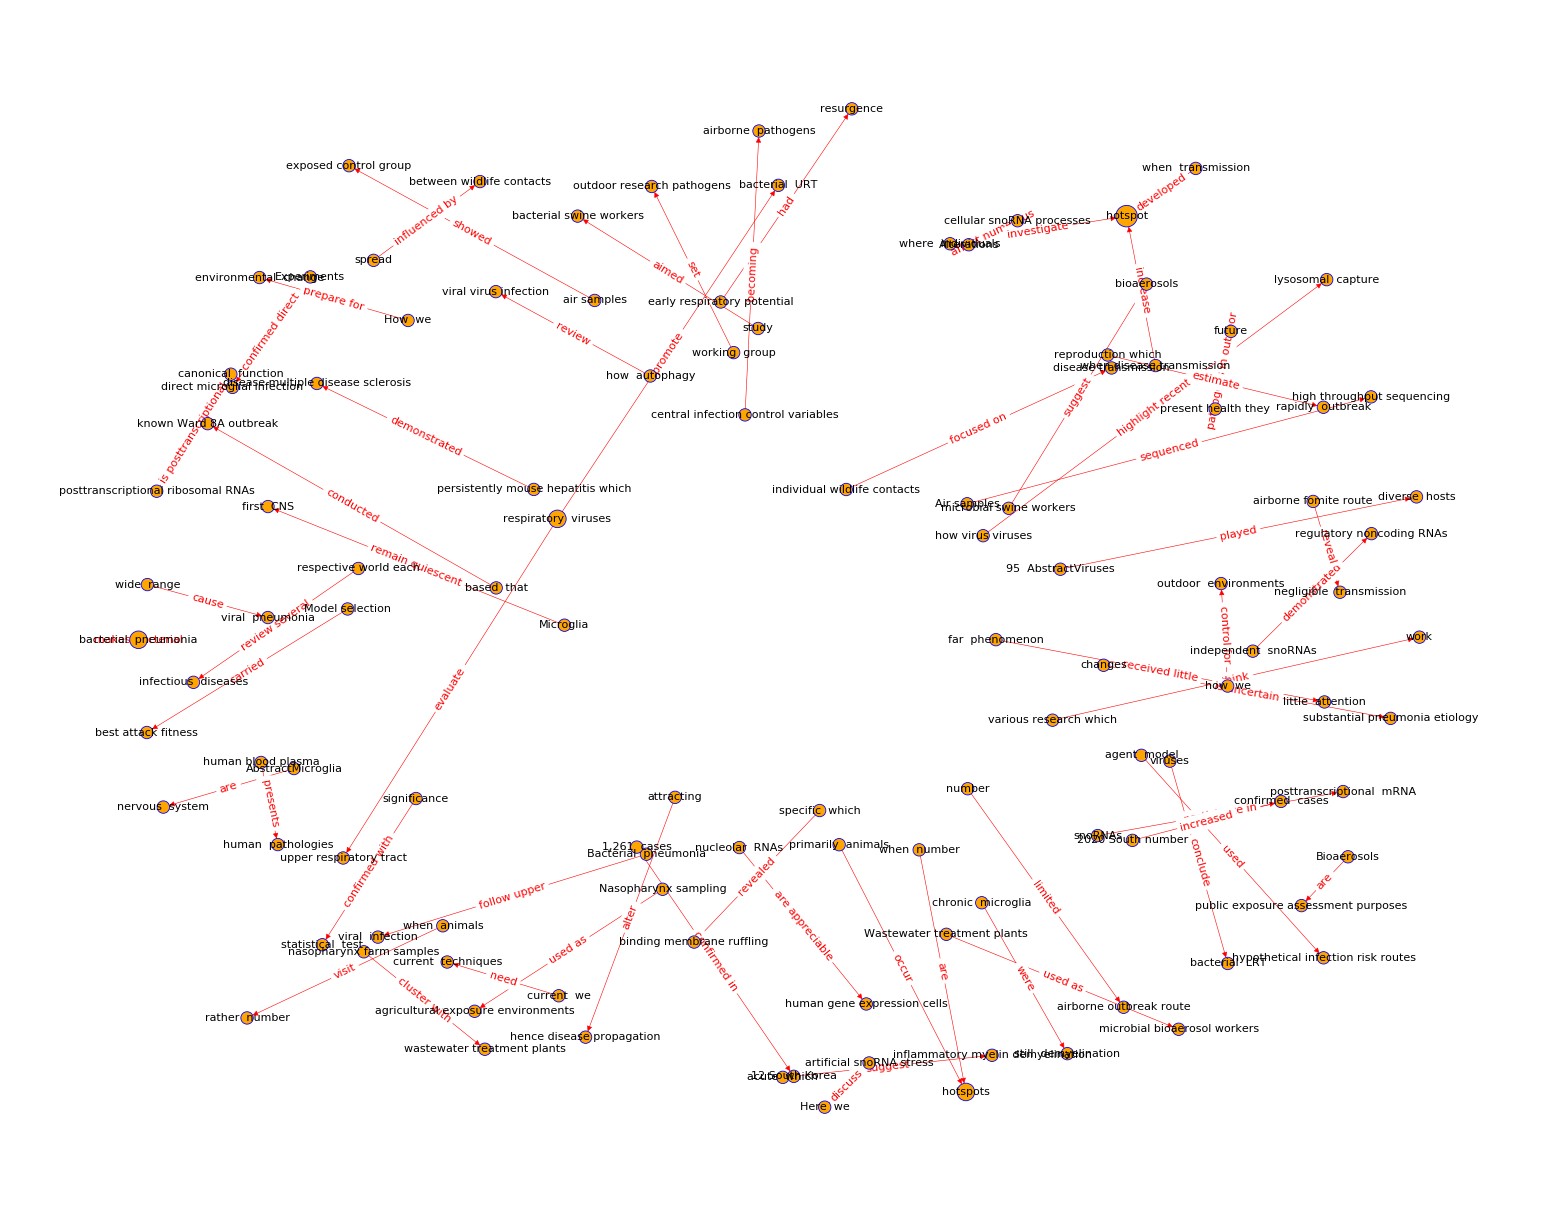

In [58]:
draw_kg(df)

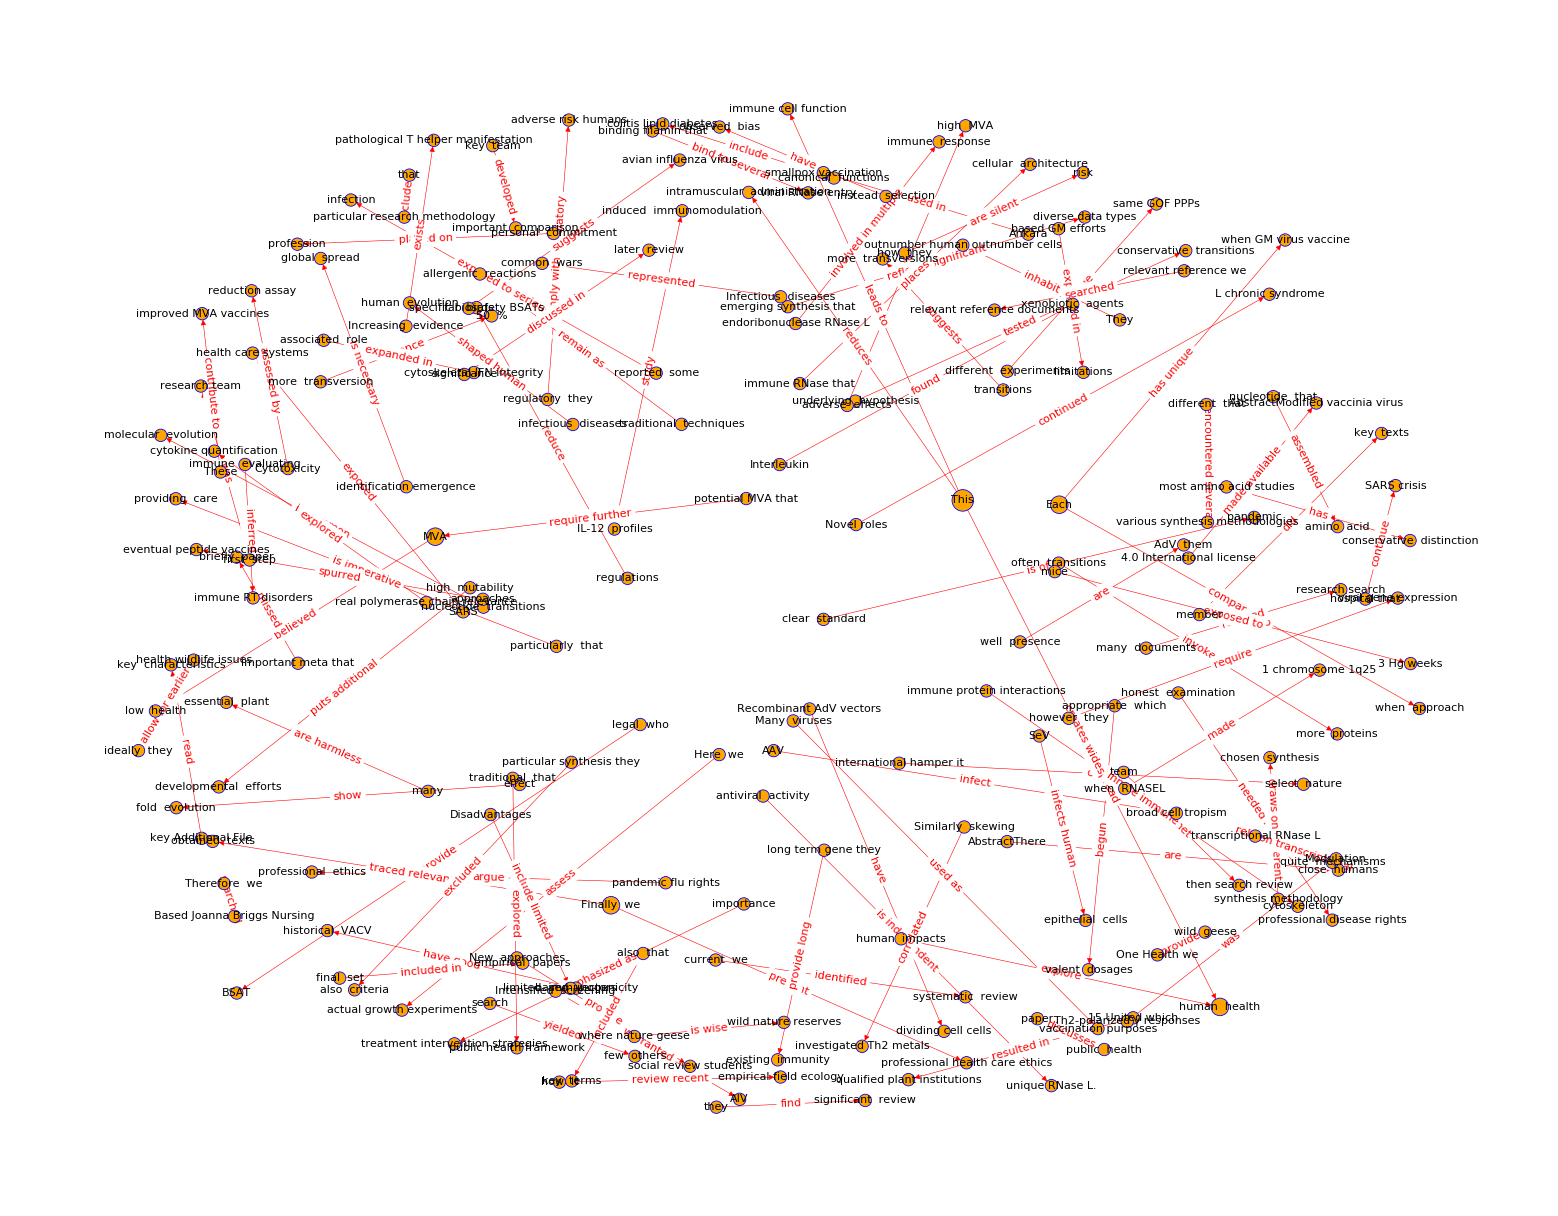

In [61]:
sentence = "What has been published about ethical and social science considerations"
similar = get_top_similar(sentence, sentence_list, embed_vectors, 15)
ind, title = list(map(list, zip(*similar)))
titles = []
texts = []
for i in ind:
    titles.append(all_articles.iloc[i]['title'])
    texts.append(all_articles.iloc[i]['abstract'])
texts = list(map(clean, texts))
text_list = ' '.join(texts)
df = prepare_df(text_list)
draw_kg(df)

In [62]:
df

,object,relation,subject
0,same GOF PPPs,argue,different experiments
1,qualified plant institutions,resulted in,15 United which
2,specific biosafety BSATs,reduce,regulations
3,BSAT,provide,legal who
4,select nature,come,international hamper it
...,...,...,...
103,reduction assay,assessed by,Cytotoxicity
104,cytokine quantification,explored,real polymerase chain relevance
105,Th2-polarized γ responses,was,Modulation
106,investigated Th2 metals,correlated,Similarly skewing
